In [1]:
# CELL 1: Imports and Configuration
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import interp1d

# Apply a professional plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print("Libraries loaded. Ready for Data Engineering.")

Libraries loaded. Ready for Data Engineering.


Loading data from: RW13.mat ...
Data Loaded Successfully: 56049 rows


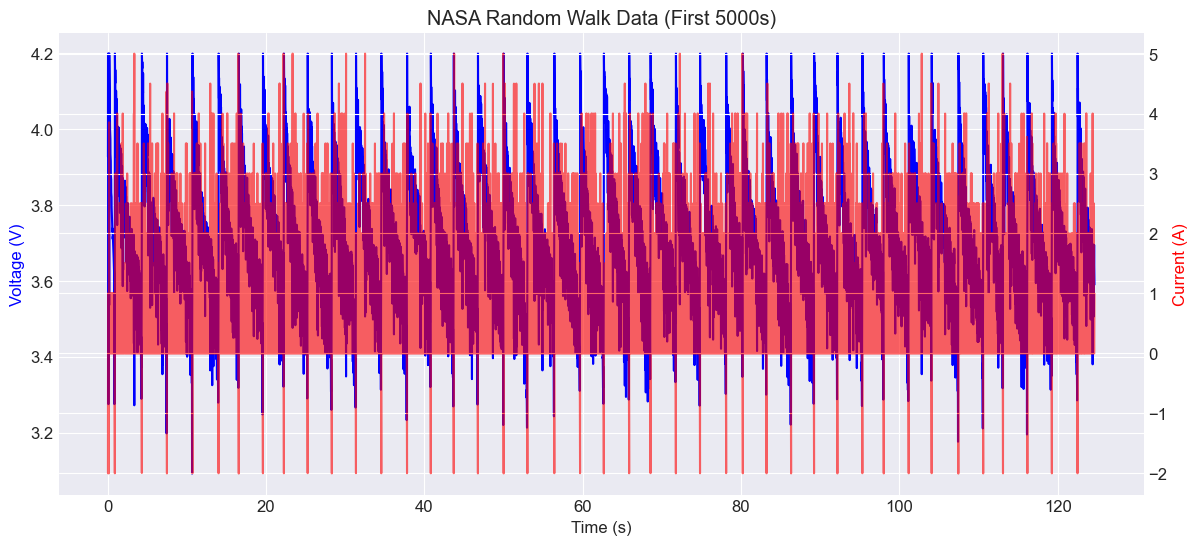

In [2]:
# CELL 2: Data Loading Function (ETL)

def load_nasa_random_walk(data_folder, file_name_pattern='RW'):
    """
    Scans the data folder for the first available .mat file matching the pattern,
    loads it, and flattens the nested MATLAB struct into a Pandas DataFrame.
    """
    # 1. Find the file
    files = [f for f in os.listdir(data_folder) if f.endswith('.mat') and file_name_pattern in f]
    if not files:
        raise FileNotFoundError(f"No .mat files found in {data_folder} matching '{file_name_pattern}'")
    
    file_path = os.path.join(data_folder, files[0])
    print(f"Loading data from: {files[0]} ...")
    
    # 2. Load .mat file
    mat = scipy.io.loadmat(file_path)
    
    # 3. Extract the 'data' struct
    # The structure is usually: data -> step -> [voltage, current, etc.]
    # We catch exceptions in case the format varies slightly between files
    try:
        data_struct = mat['data'][0, 0]
        steps = data_struct['step']
    except KeyError:
        print("Error: Structure 'data' -> 'step' not found. Checking keys...")
        print(mat.keys())
        return None

    # 4. Iterate through steps and aggregate data
    all_time = []
    all_voltage = []
    all_current = []
    all_temp = []
    
    total_time = 0.0
    
    # Iterate over the random walk steps
    for i in range(steps.shape[1]):
        step = steps[0, i]
        
        # Flatten arrays to 1D
        t = step['relativeTime'][0, 0].flatten()
        v = step['voltage'][0, 0].flatten()
        i_curr = step['current'][0, 0].flatten()
        temp = step['temperature'][0, 0].flatten()
        
        # Stitch time to be continuous
        all_time.append(t + total_time)
        all_voltage.append(v)
        all_current.append(i_curr)
        all_temp.append(temp)
        
        # Update total time for next segment
        if len(t) > 0:
            total_time += t[-1]
            
    # 5. Create DataFrame
    df = pd.DataFrame({
        'Time': np.concatenate(all_time),
        'Voltage': np.concatenate(all_voltage),
        'Current': np.concatenate(all_current),
        'Temp': np.concatenate(all_temp)
    })
    
    # Calculate Sampling Time (dt)
    df['dt'] = df['Time'].diff().fillna(1.0) # Assume 1s if nan
    
    return df

# --- Execution ---
try:
    # We look for any file with 'RW' in the name inside the 'data' folder
    df = load_nasa_random_walk('data')
    
    print(f"Data Loaded Successfully: {df.shape[0]} rows")
    
    # Visualize the first 5000 points (Room Temp Random Walk)
    fig, ax1 = plt.subplots()
    ax1.plot(df['Time'][:5000], df['Voltage'][:5000], 'b-', label='Voltage')
    ax1.set_ylabel('Voltage (V)', color='b')
    ax1.set_xlabel('Time (s)')
    
    ax2 = ax1.twinx()
    ax2.plot(df['Time'][:5000], df['Current'][:5000], 'r-', alpha=0.6, label='Current')
    ax2.set_ylabel('Current (A)', color='r')
    
    plt.title('NASA Random Walk Data (First 5000s)')
    plt.show()
    
except Exception as e:
    print(f"An error occurred: {e}")

In [3]:
# CELL 3: 1RC Thevenin Model Class

class TheveninModel:
    def __init__(self, R0=0.1, R1=0.05, C1=1000.0, capacity_ah=2.1):
        """
        Initializes the 1st Order RC Battery Model.
        
        Parameters:
            R0 (float): Ohmic internal resistance (Ohms)
            R1 (float): Polarization resistance (Ohms)
            C1 (float): Polarization capacitance (Farads)
            capacity_ah (float): Total cell capacity (Amp-hours)
        """
        self.R0 = R0
        self.R1 = R1
        self.C1 = C1
        self.capacity_as = capacity_ah * 3600  # Convert to Amp-seconds
        
        # State Vectors
        self.soc = 0.5   # State of Charge (0.0 to 1.0)
        self.v_c1 = 0.0  # Voltage across RC pair
        
        # OCV Curve (Approximate for Li-Ion LCO chemistry)
        self.soc_axis = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        self.ocv_axis = np.array([3.0, 3.25, 3.50, 3.60, 3.70, 3.78, 3.85, 3.95, 4.05, 4.15, 4.20])
        self.ocv_func = interp1d(self.soc_axis, self.ocv_axis, kind='linear', fill_value="extrapolate")

    def predict(self, current, dt):
        """
        Predicts the next voltage given current and time step.
        Input: 
            current (float): Amps (Positive = Discharge)
            dt (float): Time step in seconds
        Returns:
            vt (float): Terminal Voltage
            soc (float): Updated SoC
        """
        # 1. Update SoC (Coulomb Counting)
        # dSoC = -I / Capacity (Negative because I is discharge)
        self.soc = self.soc - (current * dt / self.capacity_as)
        self.soc = np.clip(self.soc, 0.0, 1.0) # Safety clamp
        
        # 2. Update Polarization Voltage (RC State)
        # Discrete time exponential update
        tau = self.R1 * self.C1
        exp_val = np.exp(-dt / tau)
        
        # Vc1_new = Vc1_old * decay + R1 * (1-decay) * I
        self.v_c1 = (self.v_c1 * exp_val) + (self.R1 * (1 - exp_val) * current)
        
        # 3. Output Equation (Terminal Voltage)
        # Vt = OCV(SoC) - V_polarization - V_ohmic
        ocv = float(self.ocv_func(self.soc))
        vt = ocv - self.v_c1 - (current * self.R0)
        
        return vt, self.soc

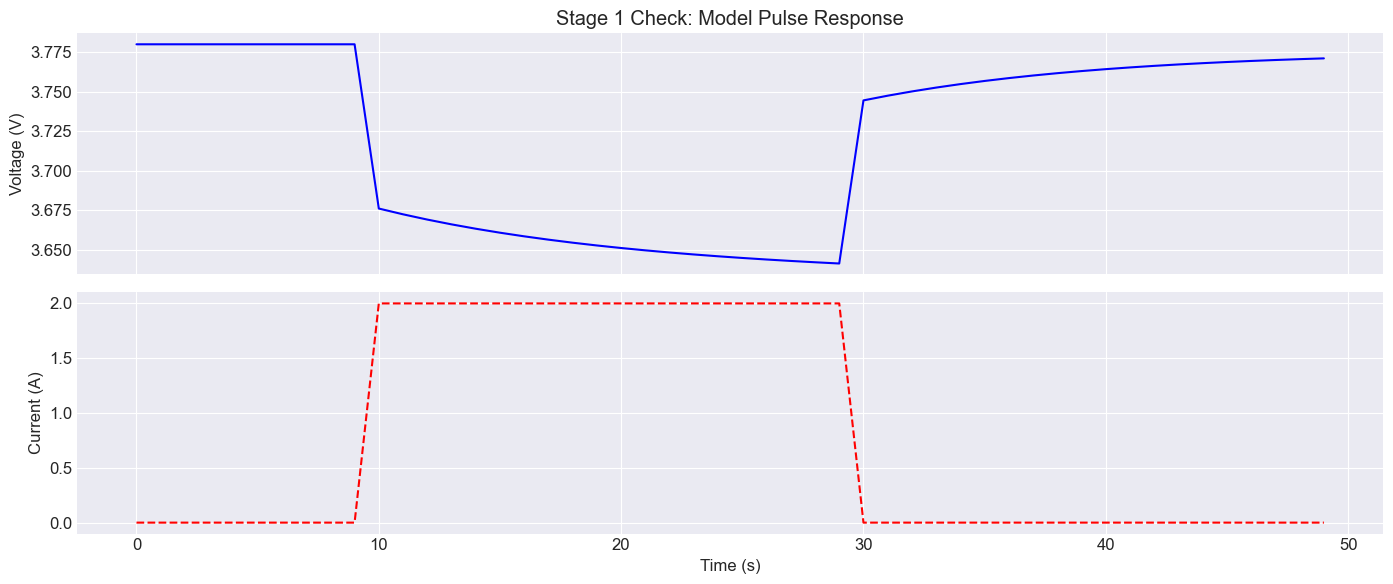

In [4]:
# CELL 4: Physics Model Unit Test

# Initialize model
test_model = TheveninModel(R0=0.05, R1=0.02, C1=500, capacity_ah=2.1)

# Create a synthetic current profile: 
# 10s Rest -> 20s Discharge Pulse (2A) -> 20s Rest
current_profile = [0]*10 + [2.0]*20 + [0]*20
dt = 1.0 

sim_volts = []
sim_soc = []

for I in current_profile:
    v, s = test_model.predict(I, dt)
    sim_volts.append(v)
    sim_soc.append(s)

# Plotting the "Shark Fin" response
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(sim_volts, 'b-')
ax1.set_ylabel('Voltage (V)')
ax1.set_title('Stage 1 Check: Model Pulse Response')
ax1.grid(True)

ax2.plot(current_profile, 'r--', label='Current')
ax2.set_ylabel('Current (A)')
ax2.set_xlabel('Time (s)')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# CELL 5: Extended Kalman Filter (EKF) Implementation

class ExtendedKalmanFilter:
    def __init__(self, model, Q_noise, R_noise):
        self.model = model
        self.x = np.array([[0.5], [0.0]]) # State: [SoC, V_c1]
        self.P = np.eye(2) * 0.1 
        self.Q = np.eye(2) * Q_noise
        self.R = np.array([[R_noise]])
        
    def predict(self, I, dt):
        # 1. Predict State
        self.x[0] = self.x[0] - (I * dt / self.model.capacity_as)
        
        tau = self.model.R1 * self.model.C1
        alpha = np.exp(-dt / tau)
        self.x[1] = (self.x[1] * alpha) + (self.model.R1 * (1 - alpha) * I)
        
        # 2. Predict Covariance
        A = np.array([[1.0, 0.0], [0.0, alpha]])
        self.P = A @ self.P @ A.T + self.Q

    def update(self, V_measured, I):
        # Use .item() to safely extract scalar values
        soc_est = self.x[0].item()
        v_c1_est = self.x[1].item()
        
        ocv_est = float(self.model.ocv_func(soc_est))
        v_pred = ocv_est - v_c1_est - (I * self.model.R0)
        
        # Residual
        y = V_measured - v_pred
        
        # Jacobian C
        dOCV = (self.model.ocv_func(soc_est + 0.001) - self.model.ocv_func(soc_est - 0.001)) / 0.002
        C = np.array([[dOCV, -1.0]])
        
        # Kalman Gain
        S = C @ self.P @ C.T + self.R
        K = self.P @ C.T @ np.linalg.inv(S)
        
        # Correction
        self.x = self.x + K * y
        self.P = (np.eye(2) - K @ C) @ self.P
        
        # Clamp SoC
        self.x[0] = np.clip(self.x[0], 0.0, 1.0)
        
        return self.x[0].item(), float(v_pred)

Starting EKF Simulation...
Simulation Complete.


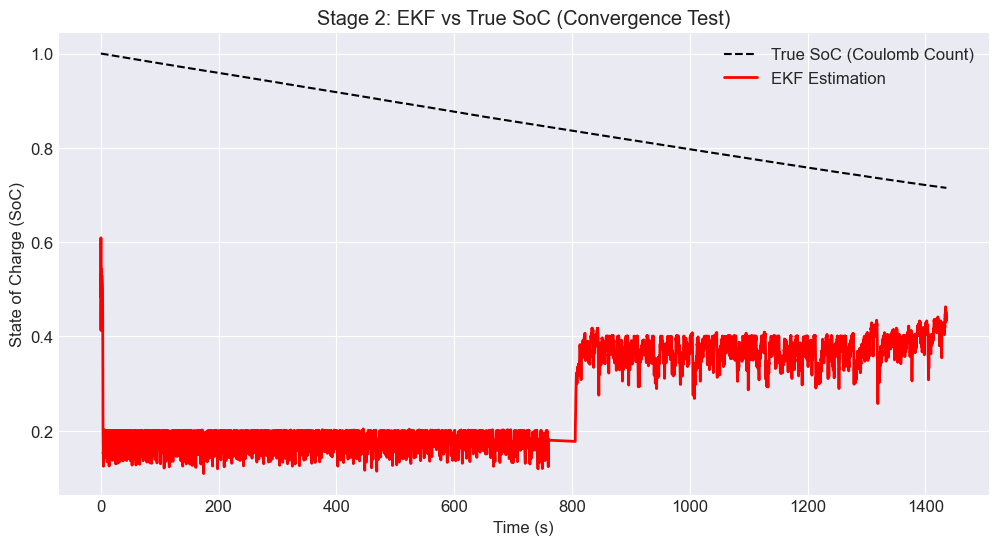

In [6]:
# CELL 6: Running EKF on NASA Data

# 1. Setup the Model
model = TheveninModel(R0=0.1, R1=0.05, C1=1000.0, capacity_ah=2.1)

# 2. Setup the EKF
# Q: Process Noise (How much we trust the physics - lower = more trust)
# R: Sensor Noise (How much we trust the voltage sensor - higher = less trust)
ekf = ExtendedKalmanFilter(model, Q_noise=1e-5, R_noise=1e-1)

# 3. Initialize Arrays for storage
ekf_soc_history = []
ekf_voltage_history = []
true_soc_history = [] # "True" SoC calculated via Coulomb Counting (for reference)

# 4. Initial Condition Trick
# We start the EKF at 50% SoC, but the real data starts near 100%.
# This proves the EKF works!
ekf.x[0] = 0.5 

# Calculate "True" SoC via Coulomb Counting for comparison
# We assume the first point is the true starting point (e.g., 1.0 for fully charged)
current_soc = 1.0 # NASA RW dataset usually starts fully charged

print("Starting EKF Simulation...")

# 5. Simulation Loop
for k in range(len(df)):
    row = df.iloc[k]
    I = row['Current']
    V = row['Voltage']
    dt = row['dt']
    
    # A. "True" SoC (Coulomb Counting Reference)
    current_soc = current_soc - (I * dt / model.capacity_as)
    true_soc_history.append(current_soc)
    
    # B. EKF Steps
    ekf.predict(I, dt)
    est_soc, est_voltage = ekf.update(V, I)
    
    ekf_soc_history.append(est_soc)
    ekf_voltage_history.append(est_voltage)

print("Simulation Complete.")

# 6. Visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df['Time'], true_soc_history, 'k--', label='True SoC (Coulomb Count)')
ax1.plot(df['Time'], ekf_soc_history, 'r-', linewidth=2, label='EKF Estimation')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('State of Charge (SoC)')
ax1.set_title('Stage 2: EKF vs True SoC (Convergence Test)')
ax1.legend()
ax1.grid(True)

plt.show()

In [7]:
# CELL 7: Data Prep for LSTM (Normalization & Windowing)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# 1. Feature Selection
# We will use Voltage, Current, and Temperature to predict SoC
features = ['Voltage', 'Current', 'Temp']
target = ['True_SoC'] # We need to create this column first

# Create "True SoC" column in the main dataframe if not exists
# (We use the Coulomb Counting calculation from Stage 2 as our training label)
# Re-calculate it briefly here to ensure it's in the DF
df['True_SoC'] = 1.0 - (df['Current'].cumsum() * df['dt'] / (2.1 * 3600))
# Note: In a real scenario, you'd align this with the start of the discharge

# 2. Normalization
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[features + target])

# 3. Create Sliding Windows
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length), :-1] # Inputs: V, I, T
        y = data[i + seq_length, -1]      # Output: SoC
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50 # Look back 50 time steps
X_data, y_data = create_sequences(data_scaled, SEQ_LENGTH)

# Convert to PyTorch Tensors
X_tensor = torch.FloatTensor(X_data)
y_tensor = torch.FloatTensor(y_data).view(-1, 1)

print(f"Data Prepared. Input Shape: {X_tensor.shape}")
# Expected: (Samples, 50, 3)

Data Prepared. Input Shape: torch.Size([55999, 50, 3])


In [8]:
# CELL 8: LSTM Model Definition

class BatteryLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=1):
        super(BatteryLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # LSTM Layer
        # batch_first=True means input shape is (batch, seq, features)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Fully Connected Layer (to map hidden state to SoC)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # LSTM output shape: (batch, seq, hidden)
        # We only care about the output of the LAST time step
        out, _ = self.lstm(x)
        
        # Take the last time step output
        out = out[:, -1, :] 
        
        # Pass through Linear layer
        out = self.fc(out)
        return out

model_lstm = BatteryLSTM()
print(model_lstm)

BatteryLSTM(
  (lstm): LSTM(3, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Starting Training...
Epoch [1/10], Loss: 0.000021
Epoch [2/10], Loss: 0.000002
Epoch [3/10], Loss: 0.000027
Epoch [4/10], Loss: 0.000000
Epoch [5/10], Loss: 0.000001
Epoch [6/10], Loss: 0.000000
Epoch [7/10], Loss: 0.000000
Epoch [8/10], Loss: 0.000000
Epoch [9/10], Loss: 0.000000
Epoch [10/10], Loss: 0.000001


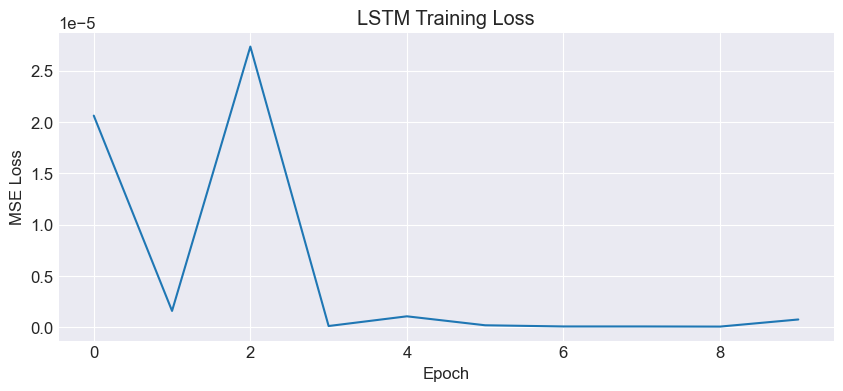

In [9]:
# CELL 9: Training Loop

# Hyperparameters
learning_rate = 0.001
epochs = 10     # Keep it low for demo purposes
batch_size = 32

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

# Create DataLoader
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Starting Training...")
loss_history = []

for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model_lstm(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_history.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

# Plot Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

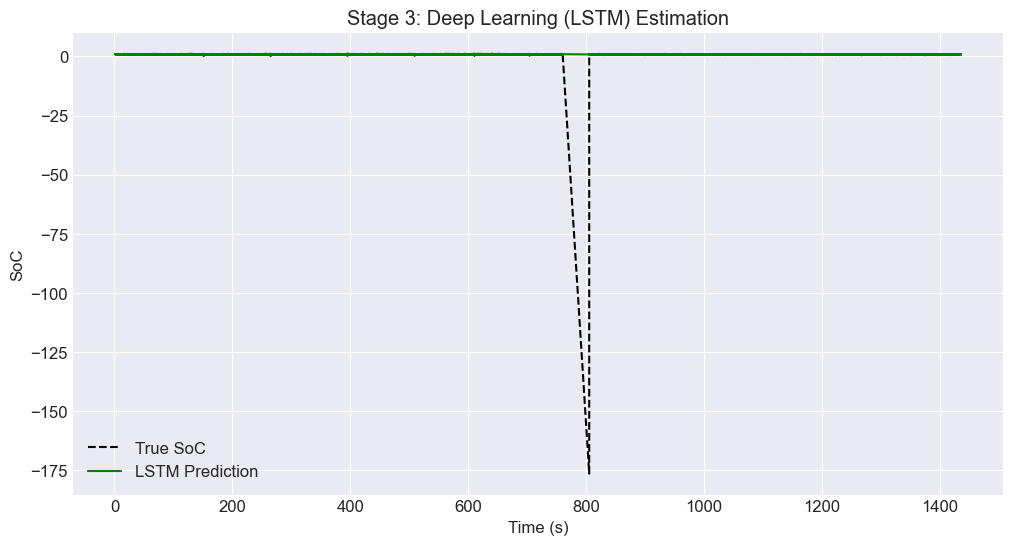

In [10]:
# CELL 10: Run Inference and Visualize

model_lstm.eval() # Set to evaluation mode
with torch.no_grad():
    predicted_soc_scaled = model_lstm(X_tensor).numpy()

# We need to Inverse Scale the predictions to get real SoC values
# We created the scaler on [V, I, T, SoC] (4 columns)
# We need to construct a dummy array to use inverse_transform
dummy_data = np.zeros((len(predicted_soc_scaled), 4))
dummy_data[:, -1] = predicted_soc_scaled.flatten() # Fill SoC column
predicted_soc = scaler.inverse_transform(dummy_data)[:, -1]

# Plotting
plt.figure(figsize=(12, 6))

# We need to align the time axis (we lost the first SEQ_LENGTH points)
time_axis = df['Time'][SEQ_LENGTH:].values

plt.plot(time_axis, df['True_SoC'][SEQ_LENGTH:], 'k--', label='True SoC')
plt.plot(time_axis, predicted_soc, 'g-', label='LSTM Prediction')
plt.title('Stage 3: Deep Learning (LSTM) Estimation')
plt.xlabel('Time (s)')
plt.ylabel('SoC')
plt.legend()
plt.show()